### Team members

1. Amirhossein Soltani
2. Moein Taherkhani

In [80]:
import numpy as np
import os
import torch
import torch.nn as nn
import yaml
from pathlib import Path
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.tensorboard import SummaryWriter


/home_domuser/s06mtahe/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Downloading the dataset


In [3]:

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


### Dataset inspection

In [4]:
print(f"# Images Train: {len(train_dataset)}")
print(f"# Images Test:  {len(test_dataset)}")

# Images Train: 50000
# Images Test:  10000


In [5]:
img_shape = train_dataset[0][0].shape
label = train_dataset[0][1]

print(f"Image shape: {img_shape}")
print(f"Label: {label}")

Image shape: torch.Size([3, 32, 32])
Label: 6


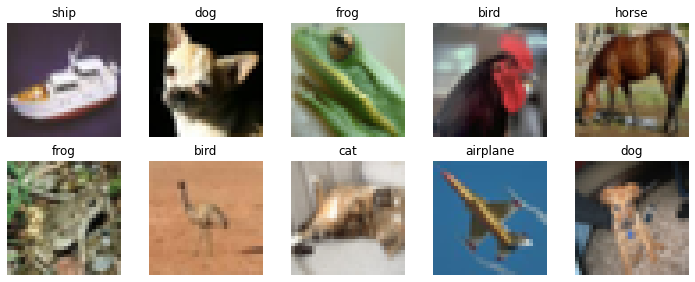

In [6]:
import matplotlib.pyplot as plt


classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]

N_IMGS = 8
fig, ax = plt.subplots(2,5)
fig.set_size_inches(10, 4)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i in range(2):
    for j in range (5):
        id = np.random.randint(0,len(train_dataset),1)[0]
        img = train_dataset[id][0].numpy().transpose((1,2,0))
        ax[i,j].imshow(img)
        ax[i,j].set_title(f"{classes[train_dataset[id][1]]}")
        ax[i,j].axis("off")
plt.tight_layout()
plt.show()


### Dataloaders

In [81]:
training_config = {'BATCH_SIZE' : 1024,
                   'lr' : 5e-5,
                   'epochs' : 200,
                   'Experiment_name': 'Exp5'
                   }

# Spliting the training dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader =  torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=True
    )

val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=training_config['BATCH_SIZE'],
    shuffle=False
)

eval_loader =  torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=training_config['BATCH_SIZE'],
        shuffle=False,
        drop_last=True
    )

## MLP

In [29]:
class Model(nn.Module):
    """
    MLP composed of two fully connected layers.
     - First layer takes pixel values and maps them to a hidden dimension
     - Nonlinear activation
     - Second layer maps from hidden dimension to number of classes, predicting a score for each of the classes
    """
    def __init__(self, input_dim=3072, hidden_dim=1024, output_dim=len(classes)):
        """ Model initalizer """
        super().__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=input_dim, out_features=hidden_dim),
                nn.ReLU(),
                nn.Linear(in_features=hidden_dim, out_features=output_dim)
            )
        
    def forward(self, x):
        """ Forward pass through the model"""
        assert len(x.shape) == 2, f"ERROR! Shape of input must be 2D (b_size, dim)"
        pred = self.layers(x)
        return pred


In [30]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model = Model().to(device)

summary(mlp_model, input_size=(3072,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
              ReLU-2                 [-1, 1024]               0
            Linear-3                   [-1, 10]          10,250
Total params: 3,157,002
Trainable params: 3,157,002
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 12.04
Estimated Total Size (MB): 12.07
----------------------------------------------------------------


In [31]:
criterion = nn.CrossEntropyLoss()  # already includes a Softmax!
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=training_config['lr'])

#### Creating a log directory to monitor different experiments

In [98]:
# Checkpoints directory
root = Path("./")
Experiment = training_config['Experiment_name']
save_dir = root/'checkpoints'/Experiment
if not os.path.exists(save_dir):
    os.makedirs(save_dir,exist_ok=True)

# Save the training configuration for each experiment
with open(os.path.join(save_dir, "training_config.yaml"), "w") as f:
    yaml.dump(training_config, f)

# Tensorboard log directory
log_dir = root/'log_dir'
log_dir = os.path.join(log_dir, Experiment)

# Initialize TensorBoard
writer = SummaryWriter(log_dir=log_dir)  


In [32]:
log_dict = {'Training_loss' : [] ,'Validation_loss' : [] }

print("##### TRAINING ... ####")
for epoch in range(training_config['epochs']):
    mlp_model.train()
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (imgs, labels) in enumerate(progress_bar):
        imgs, labels = imgs.to(device), labels.to(device)
    
        # forward pass
        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        loss = criterion(preds, labels)
        log_dict['Training_loss'].append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 10 == 0 or i == len(train_loader) - 1):
            progress_bar.set_description(f"Epoch {epoch + 1} Batch {i + 1}: loss {loss.item():.5f}. ")

        # Validation every 5 epochs
        if (epoch + 1) % 5 == 0:
            mlp_model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_imgs, val_labels in val_loader:
                    val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                    flattened_val_imgs = val_imgs.flatten(start_dim=1)
                    val_preds = mlp_model(flattened_val_imgs)
                    val_loss += criterion(val_preds, val_labels).item()
            
            avg_val_loss = val_loss / len(eval_loader)
            log_dict['Validation_loss'].append(avg_val_loss)
            print(f"\nValidation loss after epoch {epoch + 1}: {avg_val_loss:.5f}")


# Add training and validation losses to TensorBoard
for i, train_loss in enumerate(log_dict['Training_loss']):
    writer.add_scalar('Loss/train', train_loss, i)
    
for i, val_loss in enumerate(log_dict['Validation_loss']):
    writer.add_scalar('Loss/val', val_loss, i)

# Close the writer
writer.close()


##### TRAINING ... ####


Epoch 200 Batch 49: loss 0.95660. : 100%|██████████| 49/49 [00:01<00:00, 28.32it/s]


### EVALUATION

In [33]:

print("##### EVALUATION ... ####")
mlp_model.eval()
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(eval_loader), total=len(eval_loader))
    for i, (imgs, labels) in progress_bar: 
        imgs, labels = imgs.to(device), labels.to(device)

        flattened_imgs = imgs.flatten(start_dim=1)
        preds = mlp_model(flattened_imgs)

        pred_labels = torch.argmax(torch.softmax(preds, dim=-1), dim=-1)
        cur_correct = len(torch.where(pred_labels == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%") 

##### EVALUATION ... ####


100%|██████████| 9/9 [00:00<00:00, 27.72it/s]

Test accuracy: 50.35%


### Saving the model

In [34]:
if(not os.path.exists("models")):
    os.makedirs("models",exist_ok=True)
savepath = f"models/checkpoint_{training_config['Experiment_name']}.pth"

torch.save({
    'model_state_dict': mlp_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)